# Using Landsat Data to Analyze the Cameron Peak Fire
### Casey Menick, 5/5/2022

## Background

This code utilizes LANDSAT 8 data of the Cameron Peak Fire to identify change in burned area over time, calculate areas of burn severity, and assess the distribution of level-4 ecoregions located within the fire.

The Cameron Peak Fire began on August 13, 2020 and burned over 200,000 acres in the Arapaho and Roosevelt National Forests and Rocky Mountain National Park. It was finally declared 100% contained on December 2, 2020, after over $130 million dollars of expenses, involving more than 1,000 fire-fighting personnel, and causing the evacuation of over 20,000 people.

## Cameron Peak Fire Map

![Burn Progression](https://images.squarespace-cdn.com/content/v1/5af07ab53917ee099d13c874/1608052547755-MDSQY60BX1UBW0RB29QC/finalCPFburnareamap.jpeg)

## Data Sources:

https://mtbs.gov/direct-download: fire area boundary polygons

https://www.epa.gov/eco-research/ecoregion-download-files-state-region-8: level-4 ecoregions

https://earthexplorer.usgs.gov/: LANDSAT data

    07/02/2020: LC08_L1TP_034032_20200702_20200913_02_T1
    09/04/2020: LC08_L1TP_034032_20200904_20200918_02_T1
    10/06/2020: LC08_L1TP_034032_20201006_20201016_02_T1
    10/22/2020: LC08_L1TP_034032_20201022_20201105_02_T1

## Data Import and Preparation

In [1]:
import os
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rxr
from glob import glob
from rasterio.plot import plotting_extent
from matplotlib import pyplot as plt, animation
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib import colors
import earthpy.plot as ep
import earthpy.spatial as es
import numpy as np
import numpy.ma as ma
from PIL import Image
from IPython.display import HTML, display 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# set directory for the LANDSAT data; each date stored in its own folder
dir = r"G:\Other computers\My Laptop\Documents\Grad School\Classes\Spring 2022\NR427\Final Project"
folderlist = glob(f"{dir}\Landsat/*/")
folderlist.sort()

In [4]:
# import boundary of burned area, read into memory, and project to the same crs as the landsat data
boundary_path = r"boundary/co4060910587920200813_20180915_20210907_burn_bndy.shp"

if os.path.exists(boundary_path) == True:
    try:
        boundary = gpd.read_file(boundary_path)
        boundary = boundary.to_crs("EPSG:32613")
        print("Fire boundary file successfully read and projected")
    except:
        print("Fire boundary exists, but could not be read and projected")
else:
    print("Boundary path does not exist")

Fire boundary file successfully read and projected


In [5]:
# import level-4 ecoregions of Colorado, read into memory, and project to same crs as the landsat data
eco_path = r"co_eco_l4/co_eco_l4.shp"

if os.path.exists(eco_path) == True:
    try:
        eco = gpd.read_file(eco_path)
        eco = eco.to_crs("EPSG:32613")
        print("Ecoregions file successfully read and projected")
    except:
        print("Ecoregions file exists, but could not be read and projected")
else:
    print("Ecoregions path does not exist")

Ecoregions file successfully read and projected


In [6]:
# create function to combine tif files into a singular xarray object
def combine_tifs(tif_list):
    """A function that combines a list of tifs in the same CRS
    and of the same extent into an xarray object """
    out_xr = []
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"] = i+1
    return xr.concat(out_xr, dim="band")

In [7]:
# create a dictionary for all of the landsat dates and bands of interest
d = {}
for x in folderlist:
    try:
        allbands = glob(os.path.join(x,"*B[2-7]*.TIF"))
        d[format(x[-9:-1])] = combine_tifs(allbands)
        print(f"The landsat data for {x[-5:-3]}-{x[-3:-1]}-{x[-9:-5]} were successfully added to the landsat dictionary")
    except:
        print(f"Could not add {x[-5:-3]}-{x[-3:-1]}-{x[-9:-5]} to the landsat dictionary")

The landsat data for 07-02-2020 were successfully added to the landsat dictionary
The landsat data for 09-04-2020 were successfully added to the landsat dictionary
The landsat data for 10-06-2020 were successfully added to the landsat dictionary
The landsat data for 10-22-2020 were successfully added to the landsat dictionary


## Data Analysis

### Visualizing the Burned Area of Cameron Peak Fire

In [8]:
# calculate nbr band math for dates of interest
# nbr = (nir-swir)(nir+swir)
nbr_pre = (d['20200702'][3]-d['20200702'][5])/(d['20200702'][5]+d['20200702'][3])
# red = d['10222020'][2]
nbr_post = (d['20201022'][3]-d['20201022'][5])/(d['20201022'][5]+d['20201022'][3])
# red = d['10222020'][2]
dnbr = nbr_pre-nbr_post

# clip nbr rasters to the extent of the cameron peak fire boundary
try:
    nbr_pre_clipped = nbr_pre.rio.clip(boundary.geometry.values,boundary.crs)
    nbr_post_clipped = nbr_post.rio.clip(boundary.geometry.values,boundary.crs)
    dnbr_clipped = dnbr.rio.clip(boundary.geometry.values,boundary.crs)
    print("All NBR rasters were sucessfully clipped to the boundary polygon")
except:
    print("There was an issue clipping at least one NBR raster to the boundary polygon")

All NBR rasters were sucessfully clipped to the boundary polygon


In [9]:
# set different plotting extents for clipped and unclipped images
extent_landsat = plotting_extent(
    dnbr.values, dnbr.rio.transform())
extent_landsat_clipped = plotting_extent(
    dnbr_clipped.values, dnbr_clipped.rio.transform())

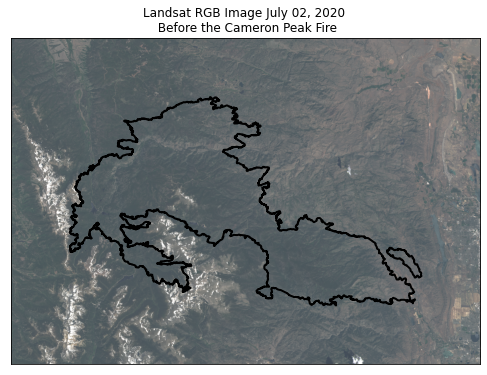

In [10]:
# create rgb basemap, plot pre-fire rgb image
landsat_bands_data_path = "Landsat/20200702/*[2-4].tif"
stack_band_paths = glob(landsat_bands_data_path)
stack_band_paths.sort()
stack_band_paths.sort(key=len)
arr_st, meta = es.stack(stack_band_paths, nodata=-9999)
    
fig, ax = plt.subplots(figsize=(12, 6))

xlim = ([boundary.geometry.total_bounds[0]-10000,  boundary.geometry.total_bounds[2]+10000])
ylim = ([boundary.geometry.total_bounds[1]-10000,  boundary.geometry.total_bounds[3]+10000])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ep.plot_rgb(arr_st, 
            rgb=(2, 1, 0),
            stretch=True,
            str_clip=1,
            ax=ax,
            extent=extent_landsat,
           title = "Landsat RGB Image July 02, 2020 \n Before the Cameron Peak Fire")

boundary.plot(ax=ax,
              color='None',
              edgecolor='black',
              linewidth=2)
plt.show()

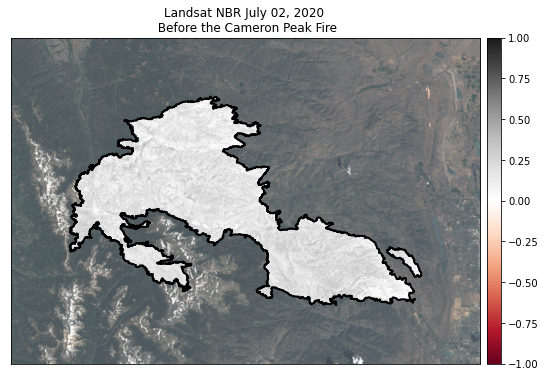

In [11]:
# plot pre-fire nbr
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ep.plot_rgb(arr_st, 
            rgb=(2, 1, 0),
            stretch=True,
            str_clip=1,
            ax=ax,
            extent=extent_landsat)

ep.plot_bands(nbr_pre_clipped,
              cmap='RdGy',
              vmin=-1,
              vmax=1,
              ax=ax,
              extent=extent_landsat_clipped,
              title="Landsat NBR July 02, 2020 \n Before the Cameron Peak Fire")

boundary.plot(ax=ax,
                       color='None',
                       edgecolor='black',
                       linewidth=2)
plt.show()

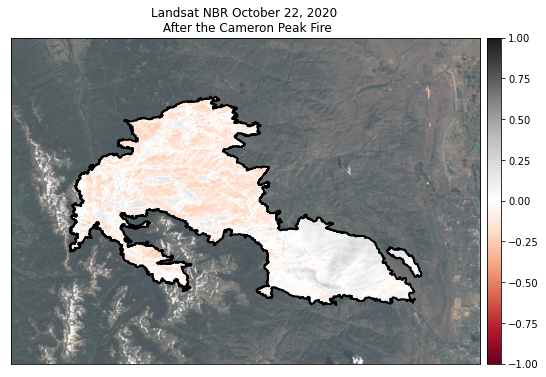

In [12]:
# plot post-fire nbr
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ep.plot_rgb(arr_st, 
            rgb=(2, 1, 0),
            stretch=True,
            str_clip=1,
            ax=ax,
            extent=extent_landsat)

ep.plot_bands(nbr_post_clipped,
              cmap='RdGy',
              vmin=-1,
              vmax=1,
              ax=ax,
              extent=extent_landsat_clipped,
              title="Landsat NBR October 22, 2020 \n After the Cameron Peak Fire")

boundary.plot(ax=ax,
                       color='None',
                       edgecolor='black',
                       linewidth=2)
plt.show()

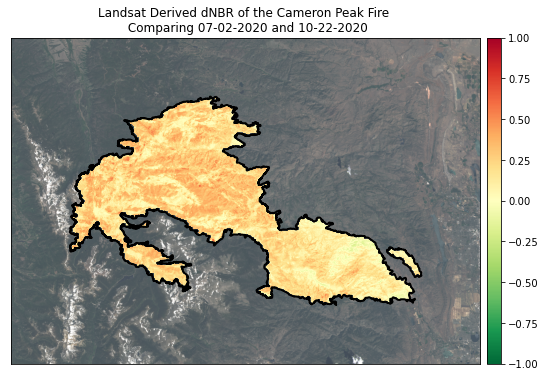

In [13]:
# plot post-fire nbr
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ep.plot_rgb(arr_st, 
            rgb=(2, 1, 0),
            stretch=True,
            str_clip=1,
            ax=ax,
            extent=extent_landsat)

ep.plot_bands(dnbr_clipped,
              cmap='RdYlGn_r',
              vmin=-1,
              vmax=1,
              ax=ax,
              extent=extent_landsat_clipped,
              title="Landsat Derived dNBR of the Cameron Peak Fire \n Comparing 07-02-2020 and 10-22-2020")

boundary.plot(ax=ax,
                       color='None',
                       edgecolor='black',
                       linewidth=2)
plt.show()

In [14]:
# create map of dnbr for each landsat image date to track burn progression
for x in d:
    nbr = (d[x][3,:,:]-d[x][5,:,:])/(d[x][3,:,:]+d[x][5,:,:])
    init_nbr = (d["20200702"][3,:,:]-d["20200702"][5,:,:])/(d["20200702"][3,:,:]+d["20200702"][5,:,:])
    dnbr = init_nbr-nbr
    dnbr_clipped = dnbr.rio.clip(boundary.geometry.values)
        
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ep.plot_rgb(arr_st, 
            rgb=(2, 1, 0),
            stretch=True,
            str_clip=1,
            ax=ax,
            extent=extent_landsat)

    ep.plot_bands(dnbr_clipped,
                  cmap='RdYlGn_r',
                  vmin=-1,
                  vmax=1,
                  ax=ax,
                  extent=extent_landsat_clipped,
                  title=f"Landsat Derived dNBR of the Cameron Peak Fire \n Comparing 07-02-2020 and {x[4:6]}-{x[-2:]}-{x[:4]}")

    boundary.plot(ax=ax,
                  color='None',
                  edgecolor='black',
                  linewidth=2)
    #plt.show()
    plt.savefig(f"{dir}/images/Python_Animation_01_frame_{x}.png")
    plt.close()

In [15]:
# join individual images, and animate into a GIF
files = glob(os.path.join(r'G:\Other computers\My Laptop\Documents\Grad School\Classes\Spring 2022\NR427\Final Project\images',"*.png"))

frames = []
for i in files:
    new_frame = Image.open(i)
    frames.append(new_frame)

frames[0].save('dnbr_change.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=900, loop=0)

![gif](dnbr_change.gif "gif")

In [16]:
# create class bins for dNBR severity levels, set to color map
dnbr_class_bins = [-np.inf, -.1, .1, .27, .66, np.inf]

dnbr_landsat_class = xr.apply_ufunc(np.digitize,
                                    dnbr,
                                    dnbr_class_bins)

dnbr_cat_names = ["Enhanced Regrowth",
                  "Unburned",
                  "Low Severity",
                  "Moderate Severity",
                  "High Severity"]

nbr_colors = ["g",
              "yellowgreen",
              "yellow",
              "orange",
              "red"]

nbr_cmap = ListedColormap(nbr_colors)

In [17]:
# save categorized dnbr as a tif file, bring into memory, and clip to boundary extent
try:
    dnbr_landsat_class.rio.to_raster("dnbr_cat.tif", compress='LZMA', tiled=True, dtype="int32")
    try:
        dnbr_cat = rxr.open_rasterio("dnbr_cat.tif", masked=True).squeeze()
        dnbr_cat_clipped = dnbr_cat.rio.clip(boundary.geometry.values)
        print("The categorized dNBR image was successfully saved and clipped to the fire boundary extent")
    except:
        print("There was an error clipping the categorized dNBR image to the fire boundary")
except:
    print("There was an error saving the categorized dNBR image as a TIF file")

The categorized dNBR image was successfully saved and clipped to the fire boundary extent


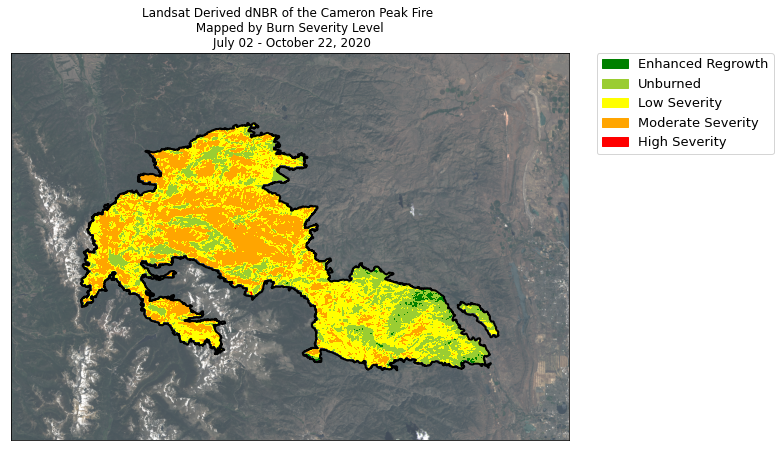

In [18]:
# plot the categorized dNBR map
fig, ax = plt.subplots(figsize=(10, 8))

boundary.plot(ax=ax,
                       color='None',
                       edgecolor='black',
                       linewidth=2)

classes = np.unique(dnbr_landsat_class)
classes = classes.tolist()[:5]

ep.plot_rgb(arr_st, 
            rgb=(2, 1, 0),
            stretch=True,
            str_clip=1,
            ax=ax,
            extent=extent_landsat)

ep.plot_bands(dnbr_cat_clipped,
              cmap=nbr_cmap,
              vmin=1,
              vmax=5,
              cbar=False,
              scale=False,
              extent=extent_landsat_clipped,
              ax=ax,
              title = "Landsat Derived dNBR of the Cameron Peak Fire \n Mapped by Burn Severity Level \n July 02 - October 22, 2020")

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ep.draw_legend(im_ax=ax.get_images()[1],
               classes=classes,
               titles=dnbr_cat_names)

plt.show()

### Calculations of the Burned Area

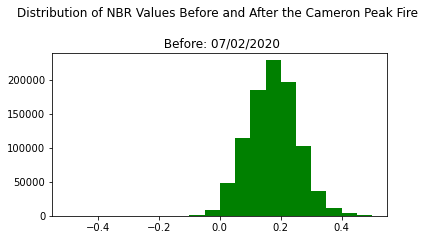

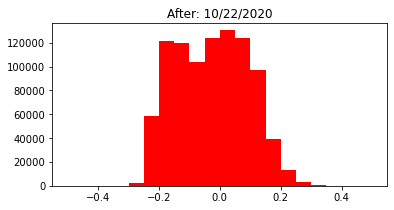

In [19]:
# plot distribution of pixels within the fire area
ep.hist(nbr_pre_clipped.values,
        figsize=(6, 3),
                hist_range= (-.5,.5),
        title=["Distribution of NBR Values Before and After the Cameron Peak Fire \n\n Before: 07/02/2020"],
       colors="green")

# plot distribution of pixels within the fire area
ep.hist(nbr_post_clipped.values,
        figsize=(6, 3),
        hist_range= (-.5,.5),
        title=["After: 10/22/2020"],
       colors="red")

plt.show()

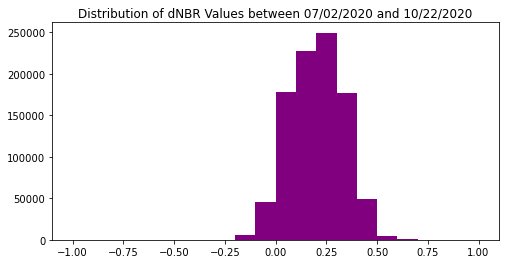

In [20]:
# plot distribution of pixels within the fire area
ep.hist(dnbr_clipped.values,
        figsize=(8, 4),
        hist_range= (-1,1),
        title=["Distribution of dNBR Values between 07/02/2020 and 10/22/2020"])

plt.show()

In [21]:
# total number of acres in the defined burn area
print("{:,}".format(round(sum(boundary.area)/4047)),"acres")

208,744 acres


In [22]:
list = [1,2,3,4,5]

print("Area within Cameron Peak Fire Burn Area, by dNBR Category:")
for i in list:
    burned_landsat = (dnbr_cat_clipped == i).sum()
    print("\t", dnbr_cat_names[i-1], ": ", "{:,}".format(round((burned_landsat.values/4047)*900)),"acres",round(100*(900*burned_landsat.values/4047)/(sum(boundary.area)/4047),2),"%")


Area within Cameron Peak Fire Burn Area, by dNBR Category:
	 Enhanced Regrowth :  1,361 acres 0.65 %
	 Unburned :  49,692 acres 23.81 %
	 Low Severity :  89,976 acres 43.1 %
	 Moderate Severity :  67,649 acres 32.41 %
	 High Severity :  58 acres 0.03 %


### Assessment of the Burn Across Level-4 Ecoregions

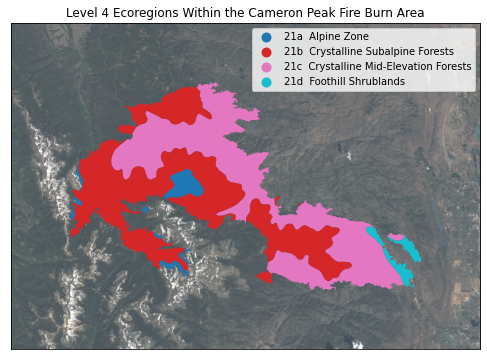

In [23]:
# intersect the fire boundary with the colorado level-4 ecoregions polygons, plot

eco_fire = gpd.overlay(boundary,eco,how='intersection')

fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlim(xlim)
ax.set_ylim(ylim)

eco_fire.plot(ax=ax,
              categorical=True,
              column='L4_KEY',
              legend=True)

ep.plot_rgb(arr_st, 
            rgb=(2, 1, 0),
            stretch=True,
            str_clip=1,
            ax=ax,
            extent=extent_landsat,
            title = "Level 4 Ecoregions Within the Cameron Peak Fire Burn Area")

plt.show()

In [24]:
# List the acreage that each ecoregion represents in the burn boundary 
eco_list = np.unique(eco_fire['L4_KEY'])

print("Area of Cameron Peak Fire Burn Area, By Level-4 Ecoregions:")
for x in eco_list:
    print(x)
    eco_select = eco_fire[eco_fire['L4_KEY']==x]
    print(f"\t{round(sum(eco_select.area)/4047)} acres")

Area of Cameron Peak Fire Burn Area, By Level-4 Ecoregions:
21a  Alpine Zone
	7894 acres
21b  Crystalline Subalpine Forests
	99823 acres
21c  Crystalline Mid-Elevation Forests
	95900 acres
21d  Foothill Shrublands
	5127 acres


In [25]:
# list the proportion of burn severity within each ecoregion
print("Burn Severity by Level-4 Ecoregion")
list2 = [1,2,3,4]
for x in list2:
    print(eco_list[x-1])
    eco_select = eco_fire[eco_fire['L4_KEY']==eco_list[x-1]]
    eco_fire_clipped = dnbr_cat_clipped.rio.clip(eco_select.geometry.values,eco_select.crs)
    for i in list:
        burned_landsat = (eco_fire_clipped == i).sum()
        print("\t",dnbr_cat_names[i-1],": ",round(burned_landsat.values*900/4047),"acres,",round(100*(burned_landsat.values*900/4047)/round(sum(eco_select.area)/4047),1),"%")


Burn Severity by Level-4 Ecoregion
21a  Alpine Zone
	 Enhanced Regrowth :  0 acres, 0.0 %
	 Unburned :  2174 acres, 27.5 %
	 Low Severity :  3232 acres, 40.9 %
	 Moderate Severity :  2487 acres, 31.5 %
	 High Severity :  1 acres, 0.0 %
21b  Crystalline Subalpine Forests
	 Enhanced Regrowth :  187 acres, 0.2 %
	 Unburned :  19255 acres, 19.3 %
	 Low Severity :  42151 acres, 42.2 %
	 Moderate Severity :  38172 acres, 38.2 %
	 High Severity :  55 acres, 0.1 %
21c  Crystalline Mid-Elevation Forests
	 Enhanced Regrowth :  1001 acres, 1.0 %
	 Unburned :  24663 acres, 25.7 %
	 Low Severity :  43303 acres, 45.2 %
	 Moderate Severity :  26923 acres, 28.1 %
	 High Severity :  2 acres, 0.0 %
21d  Foothill Shrublands
	 Enhanced Regrowth :  172 acres, 3.4 %
	 Unburned :  3600 acres, 70.2 %
	 Low Severity :  1290 acres, 25.2 %
	 Moderate Severity :  67 acres, 1.3 %
	 High Severity :  0 acres, 0.0 %


In [26]:
# create dataframe of the ecoregion burn severity
df = pd.DataFrame(columns=["row","eco","severity","acres","percent"])
df.row=range(20)

for x in list2:
    eco_select = eco_fire[eco_fire['L4_KEY']==eco_list[x-1]]
    eco_fire_clipped = dnbr_cat_clipped.rio.clip(eco_select.geometry.values,eco_select.crs)
    for i in list:
        burned_landsat = (eco_fire_clipped == i).sum()
        df.eco[(x-1)*5+i-1] = eco_list[x-1]
        df.severity[(x-1)*5+i-1] = dnbr_cat_names[i-1]
        df.acres[(x-1)*5+i-1] = burned_landsat.values*900/4047
        df.percent[(x-1)*5+i-1] = round(100*(burned_landsat.values*900/4047)/round(sum(eco_select.area)/4047),1)
        
df.drop('row', axis=1, inplace=True)
dfdisp = df.set_index(['eco', 'severity'])
dfdisp

acres percent
eco                                    severity                               
21a  Alpine Zone                       Enhanced Regrowth           0.0     0.0
                                       Unburned            2173.610082    27.5
                                       Low Severity        3231.727205    40.9
                                       Moderate Severity   2486.508525    31.5
                                       High Severity          1.334322     0.0
21b  Crystalline Subalpine Forests     Enhanced Regrowth    187.472202     0.2
                                       Unburned           19254.707191    19.3
                                       Low Severity       42151.223128    42.2
                                       Moderate Severity  38172.498147    38.2
                                       High Severity         54.707191     0.1
21c  Crystalline Mid-Elevation Forests Enhanced Regrowth   1001.408451     1.0
                                       Unburned           24663.157895    25.7
                                       Low Severity       43302.965159    45.2
                                       Moderate Severity  26922.831727    28.1
                                       High Severity          1.779096     0.0
21d  Foothill Shrublands               Enhanced Regrowth    171.905115     3.4
                                       Unburned            3600.222387    70.2
                                       Low Severity        1289.621942    25.2
                                       Moderate Severity     67.383247     1.3
                                       High Severity               0.0     0.0

Text(0, 0.5, 'Percent (%)')

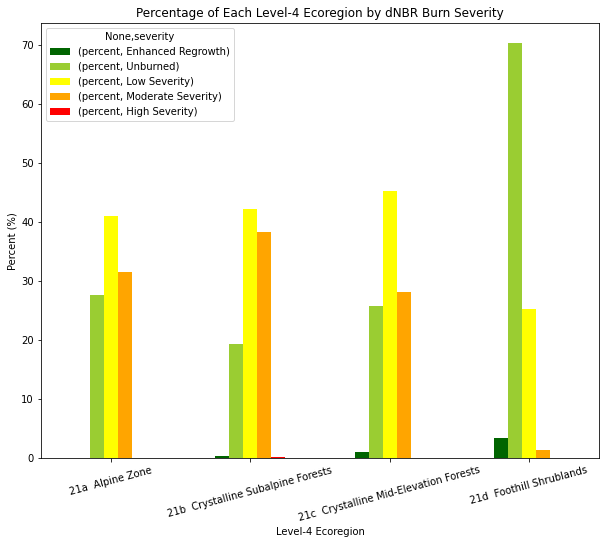

In [27]:
# plot the distribution of burn severity by ecoregion
dfplot = df[["eco","severity","percent"]]

from pandas.api.types import CategoricalDtype
severity_order= CategoricalDtype(
    ['Enhanced Regrowth', 'Unburned', 'Low Severity', 'Moderate Severity', 'High Severity'], 
    ordered=True
)

dfplot['severity'] = dfplot['severity'].astype(severity_order)

dfplot = dfplot.set_index(['eco', 'severity'])

ax = dfplot.unstack().plot(kind='bar',
                      color=["darkgreen","yellowgreen","yellow","orange","red"],
                      figsize=(10,8),
                      title="Percentage of Each Level-4 Ecoregion by dNBR Burn Severity",
                      rot=15)

ax.set_xlabel("Level-4 Ecoregion")
ax.set_ylabel("Percent (%)")

### References:

#### LANDSAT Data
https://repopython.com/r/yannforget/landsatxplore: how to search for and download landsat data programmatically

https://gis.stackexchange.com/questions/357490/mask-xarray-dataset-using-a-shapefile: clipping from polygons with rioxarray 

#### Raster Calculations
https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/calculate-NDVI-python/: Calculating NDVI and NBR with Landsat data

https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/landsat-in-Python/: working with LANDSAT data 

https://cbmjournal.biomedcentral.com/articles/10.1186/s13021-016-0055-8/tables/2: spectral band ratios

https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio: NBR

#### Plotting

https://earthpy.readthedocs.io/en/latest/api/earthpy.plot.html: spectral plotting

https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_rgb.html: rgb plotting

https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-customize-map-legends-geopandas/ polygon plotting

https://matplotlib.org/stable/gallery/color/colormap_reference.html: color mapping

https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html: color mapping

https://stackoverflow.com/questions/34248741/plotting-pandas-multiindex-bar-chart: bar plots


#### Making GIFs

https://climate-cms.org/posts/2019-09-03-python-animation.html: creating png frames from plots

https://pythonprogramming.altervista.org/png-to-gif/: converting pngs to animated gif

#### Misc
https://pythonguides.com/python-format-number-with-commas/#:~:text=In%20Python%2C%20to%20format%20a,thousand%20places%20starting%20from%20left.&text=After%20writing%20the%20above%20code,appear%20as%20a%20%E2%80%9C%205%2C000%2C000%E2%80%9D. : formatting numbers


#### Cameron Peak Fire

https://inciweb.nwcg.gov/photos/COARF/2020-08-14-0842-Cameron-Peak/picts/2020_10_27-06.48.43.886-CDT.jpeg: Cameron Peak Fire Burn Progression

https://en.wikipedia.org/wiki/Cameron_Peak_Fire: Cameron Peak Fire background
